Inspired by: https://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html

In [1]:
library(tidyverse)
library(yaml)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
data_config_id <- "pooling_sim"

In [3]:
data_config <- yaml.load_file(paste0("../data/configs/", data_config_id, "/data.yaml"))

In [4]:
data_base_dir <- paste0("../", data_config$output_dir)
data_path <- paste0(data_base_dir, "/data.csv")
if (!dir.exists(data_base_dir)) {
    dir.create(data_base_dir, recursive = TRUE)
}

In [5]:
N_per_group <- data_config$N_per_group
N_groups <- data_config$N_groups
N_obs <- N_groups * N_per_group

beta_0 <- data_config$beta_0
beta_1 <- data_config$beta_1
sigma_group <- data_config$sigma_group
sigma_individual <- data_config$sigma_individual
sigma_measurement <- data_config$sigma_measurement

min_x <- data_config$min_x
max_x <- data_config$max_x

data_seed <- data_config$seed
n_measurements <- data_config$n_measurements

Our true data generating process

$y_{ijr} = \beta_{0} + \beta_{1} X_{ij} + u_{0j} + p_{0i} + e_{ijr}$

Where:
- $r$ denotes the measurement number (we assume repeated measurements)
- $y_{ij} \sim \mathcal{N}(\beta_{0} + \beta_{1} X_{ij} + u_{0j} + p_{0i}, \sigma_{\text{measurement}})$ = response for individual $i$ in group $j$ (for a given $r$)
- $u_{0j} \sim \mathcal{N}(0, \sigma_{\text{group}})$ = the group-level effect for group $j$
- $p_{0i} \sim \mathcal{N}(0, \sigma_{\text{individual}})$ = the individual-level effect for individual $i$
- $X_{ij}$ = observed measurement for individual $i$ in group $j$
- $e_{ijr} \sim \mathcal{N}(0, \sigma_{\text{measurement}})$ = measurement error for a given observation

## Simulate data

In [6]:
set.seed(data_seed)

In [7]:
# Evenly distribute all possible values of x among a group
# Unique number of values of x must be evenly divisible by group size
x_values <- rep(min_x:max_x, length.out = N_per_group)

In [8]:
N_per_group

[1] 50

In [9]:
# First, create groups with group effects
data_df <- tibble(
        group_id = 1:N_groups,
        group_effect = rnorm(N_groups, 0, sigma_group)
    ) %>%
    # Now, add individuals into each group and:
    # 1) assigned value of x
    # 2) individual effects
    inner_join(
        tibble(
            group_id = rep(1:N_groups, each=N_per_group),
            x = rep(x_values, N_groups),
            indiv_effect = rnorm(N_obs, mean = 0, sd = sigma_individual),
            indiv_id = 1:N_obs
        ),
        by="group_id"
    ) %>%
    # Now, simulate repeated measurements:
    # 1) duplicate individuals n_measurements times
    # 2) assign a measurement id (1:n_measurements) to each duplicate row
    # 3) generate measurement error for each measurement
    # 4) compute y based on betas, effects, and measurement error
    slice(rep(1:n(), each = n_measurements)) %>%
    group_by(indiv_id) %>%
    mutate(measurement_id = 1:n()) %>%
    ungroup() %>%
    mutate(
        measurement_error_term = rnorm(N_obs * n_measurements, mean = 0, sd = sigma_measurement),
        y = beta_0 + beta_1 * x + group_effect + indiv_effect + measurement_error_term
    )

In [10]:
data_df %>%
    head()

group_id,group_effect,x,indiv_effect,indiv_id,measurement_id,measurement_error_term,y
<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,6.854792,0,1.304870,1,1,0.55748590,18.71715
1,6.854792,0,1.304870,1,2,-0.20647243,17.95319
1,6.854792,0,1.304870,1,3,-0.56448870,17.59517
1,6.854792,1,2.286645,2,1,-0.04396567,20.09747
1,6.854792,1,2.286645,2,2,1.12095185,21.26239
1,6.854792,1,2.286645,2,3,1.02065659,21.16209


In [11]:
data_df %>% pull(y) %>% quantile()

0%       25%       50%       75%      100% 
 5.526942 11.411668 13.941921 17.805072 26.958865

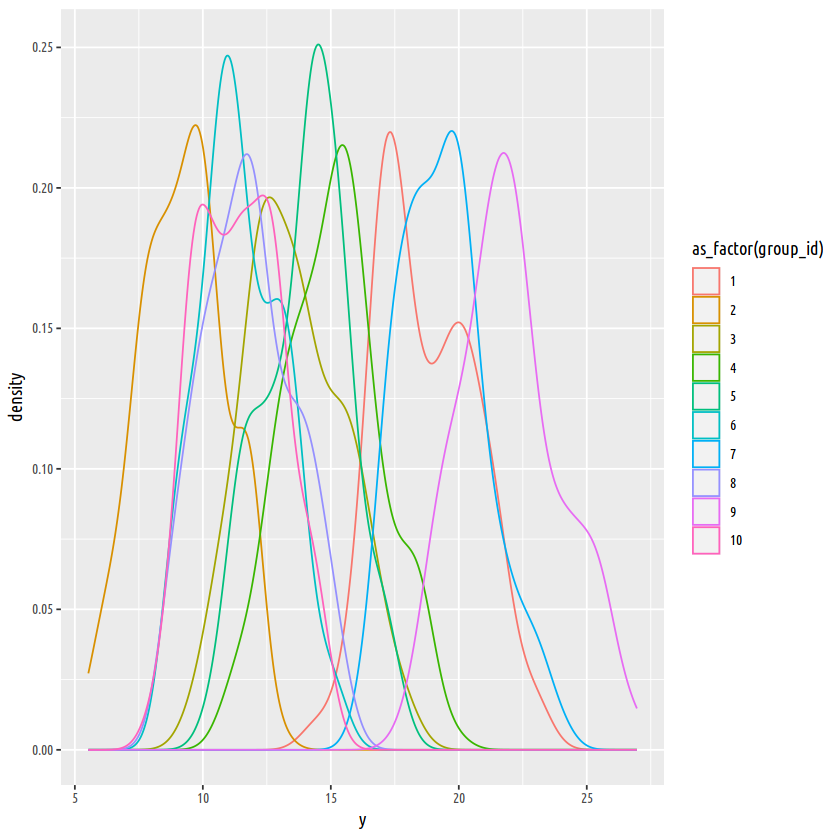

In [12]:
data_df %>%
    ggplot() +
    # geom_density(aes(x = y))
    # geom_point(aes(x = x, y = y, color = as_factor(group_id)))
    geom_density(aes(x = y, group = as_factor(group_id), color = as_factor(group_id)))

In [21]:
# Each pair (group_id, x) should have the same number
# of instances
# example, for X = {1,2} and group sizes of 6
# each group should have 3 records with x=1, 3 records with x=2
data_df %>%
    group_by(group_id, x) %>%
    count() %>%
    ungroup() %>%
    distinct(n) %>%
    nrow()

[1] 1

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


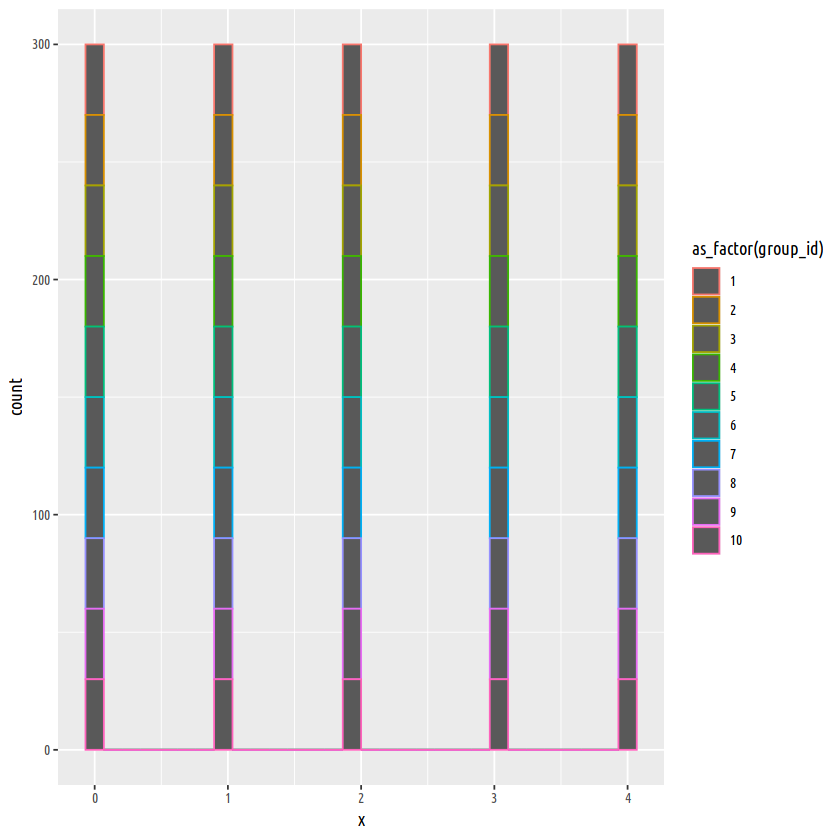

In [13]:
data_df %>%
    ggplot() +
    geom_histogram(aes(x = x, color = as_factor(group_id)))

In [14]:
data_df %>%
    write_csv(data_path)